<b>Programming Exercise 5 | Regularized Linear Regression and Bias v.s. Variance </b>

In this exercise, we implement regularized linear regression and use it to study models with different bias-variance properties. 

In [13]:
import os 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.special import expit #Vectorized sigmoid function

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

In [14]:
os.chdir('/Users/christinakouride/Documents/Python/Learning/Andrew Ng - ML course/ex5')

data = scipy.io.loadmat('ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [15]:
Xtrain = np.column_stack((np.ones(len(data['X'])), data['X']))
Ytrain = data['y']

Xtest = np.column_stack((np.ones(len(data['Xtest'])), data['Xtest']))
Ytest = data['ytest']

Xval = np.column_stack((np.ones(len(data['Xval'])), data['Xval']))
Yval = data['yval']

<b> 1.1 | Visualing data </b>

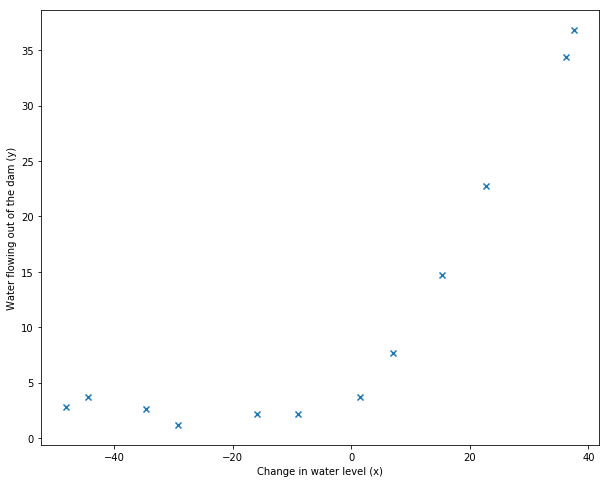

In [16]:
plt.figure(figsize=(10,8))
plt.scatter(Xtrain[:,1],Ytrain,marker='x')
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")

<b>1.2 & 1.3 | Regularized linear regression cost function and gradient</b>

In [17]:
def linearRegCostFunction(theta, Xs, Ys, lmbda):
    J = 0
    theta = theta.reshape(-1,1)
    H = np.dot(Xs,theta)
    m = Xs.shape[0]
    
    J = (1/(2*m))*np.sum((H - Ys)**2) + (lmbda/(2*m))*np.sum(theta[1:]**2)
    
    return J
    

def lrgradientReg(theta, Xs, Ys, lmbda):
    theta = theta.reshape(-1,1)
    H = np.dot(Xs,theta)
    m = Xs.shape[0]
    
    grad = (1/m)*(Xs.T.dot(H-Ys))+ (lmbda/m)*np.r_[[[0]],theta[1:]]
    
    return grad.flatten()

In [18]:
theta = np.ones((Xtrain.shape[1],1))

print('Cost:',linearRegCostFunction(theta, Xtrain, Ytrain, 0))
print('Gradient:',lrgradientReg(theta, Xtrain, Ytrain, 0))

Cost: 303.9515255535976
Gradient: [-15.30301567 598.16741084]


<b>1.4 | Fitting linear regression </b>

In [19]:
def trainLinearReg(Xs, Ys, lmbda):   
    
    theta = np.zeros([Xs.shape[1], 1])
    
    res = minimize(fun = linearRegCostFunction, x0 = theta, args = (Xs, Ys, lmbda), method='CG', jac = lrgradientReg, options={'maxiter':100})
    
    return res

In [21]:
print('Cost:',trainLinearReg(Xtrain, Ytrain, 0).fun)
print('Gradient:',trainLinearReg(Xtrain, Ytrain, 0).jac)
print('Thetas:',trainLinearReg(Xtrain, Ytrain, 0).x)

Cost: 22.373906495108912
Gradient: [-5.03301104e-15  6.95739762e-14]
Thetas: [13.08790351  0.36777923]


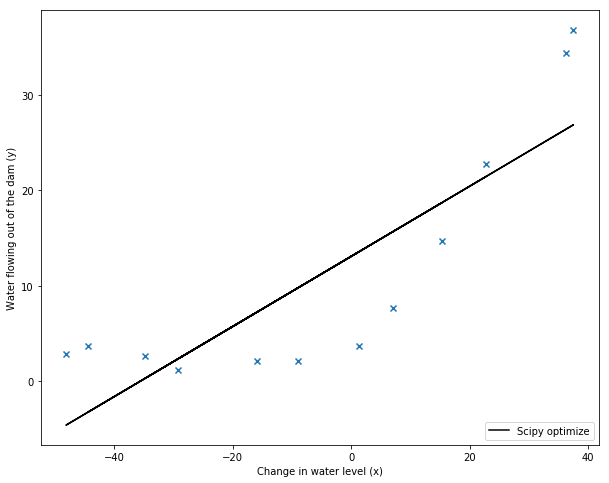

In [22]:
#plot data
plt.figure(figsize=(10,8))
plt.scatter(Xtrain[:,1],Ytrain,marker='x')
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")

fit_line=np.dot(Xtrain, trainLinearReg(Xtrain, Ytrain, 0).x)
plt.plot(Xtrain[:,1],fit_line,c='k', label='Scipy optimize')

plt.legend(loc=4)

<b>2 | Bias-variance </b>

<b> 2.1 | Learning curves </b>

In [24]:
def learningCurve(Xtrain, Ytrain, Xval, Yval, lmda):
    
    m = Xtrain.shape[0]
    
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    theta = np.zeros((Xtrain.shape[1], 1))
    
    for i in range(m):
        res = trainLinearReg(Xtrain[:i+1], Ytrain[:i+1], lmda)
        theta = res.x.reshape(Xtrain.shape[1],1)
        
        htrain = np.dot(Xtrain[:i+1], theta)
        hval = np.dot(Xval, theta)
        
        error_train[i] = np.sum((htrain - Ytrain[:i+1])**2)/(2*(i+1))
        error_val[i] = np.sum((hval - Yval)**2)/(2*Xval.shape[0])
    
    return error_train, error_val

In [25]:
error_train, error_val = learningCurve(Xtrain, Ytrain, Xval, Yval, 0)

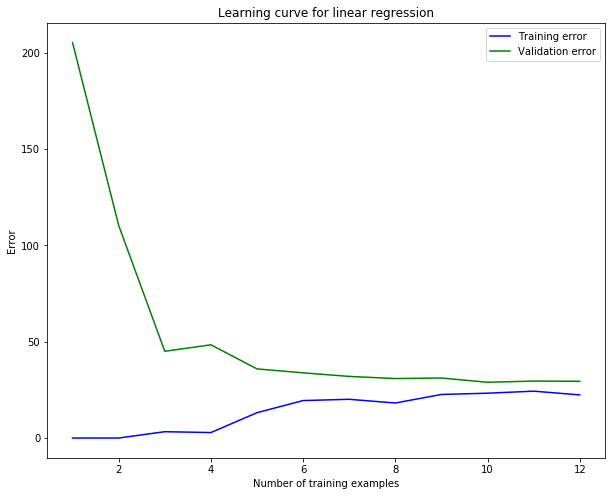

In [26]:
#plot data
x = np.arange(1,error_train.size + 1)

plt.figure(figsize=(10,8))
plt.plot(x,error_train,color='blue', label='Training error')
plt.plot(x,error_val,color='green', label='Validation error')

plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.title("Learning curve for linear regression")

plt.legend(loc=1)

<b> 3 | Polynomial regression </b>

In [29]:
#Feature mapping. Note Xs include the bias unit
def map_features(Xs, degree):
    for i in range(2,degree+1):
        new_feature = np.power(Xs[:,0],i)
        Xs = np.column_stack((Xs, new_feature))      
    return Xs

#Normalisation
def normalise(Xs):
    n_features = Xs.shape[1]

    mu = np.array([np.mean(Xs[:,i]) for i in range(n_features)])
    sigma = np.array([np.std(Xs[:,i]) for i in range(n_features)])
    
    Xs = (Xs - mu)/sigma
    return Xs, mu, sigma

In [31]:
Xpolytrain = map_features(np.delete(Xtrain, 0, 1), 8)
Xnormtrain, mu, sigma = normalise(Xpolytrain)
Xpolytrain = np.column_stack((np.ones(len(Xpolytrain)), Xnormtrain))

Xpolyval = map_features(np.delete(Xval, 0, 1), 8)
Xpolyval = np.column_stack((np.ones(len(Xpolyval)), (Xpolyval - mu)/sigma))

Xpolytest = map_features(np.delete(Xtest, 0, 1), 8)
Xpolytest = np.column_stack((np.ones(len(Xpolytest)), (Xpolytest - mu)/sigma))

<b> 3.1 | Learning Polynomial Regression </b>

In [32]:
theta = trainLinearReg(Xpolytrain,Ytrain, 0).x.reshape(-1,1)

In [34]:
X = np.arange( np.amin(Xtrain) - 15, np.amax(Xtrain) + 25, 0.05 ).reshape(-1,1)

Xpoly = map_features(X, 8)
Xpoly = np.column_stack((np.ones(len(Xpoly)), (Xpoly - mu)/sigma))

fit_poly_line = Xpoly.dot(theta)

(-80, 80)

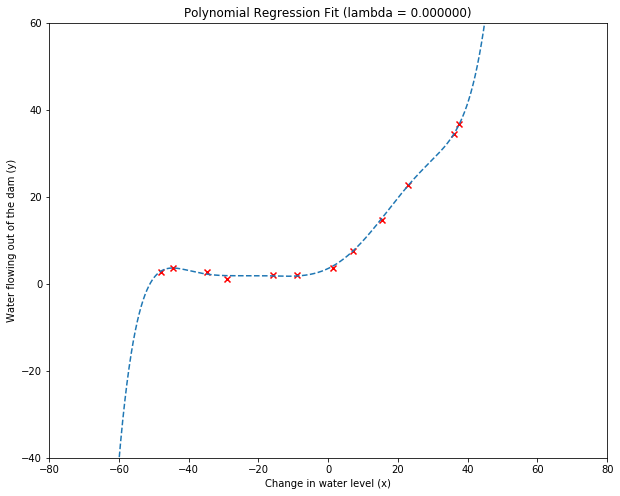

In [35]:
#plot data
plt.figure(figsize=(10,8))
plt.scatter(Xtrain[:,1],Ytrain,marker='x',c='r')
plt.plot(X, fit_poly_line, '--')

#Format chart
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.title('Polynomial Regression Fit (lambda = 0.000000)')
plt.ylim(-40,60)
plt.xlim(-80,80)

In [36]:
error_train, error_val = learningCurve(Xpolytrain, Ytrain, Xpolyval, Yval, 0.0)

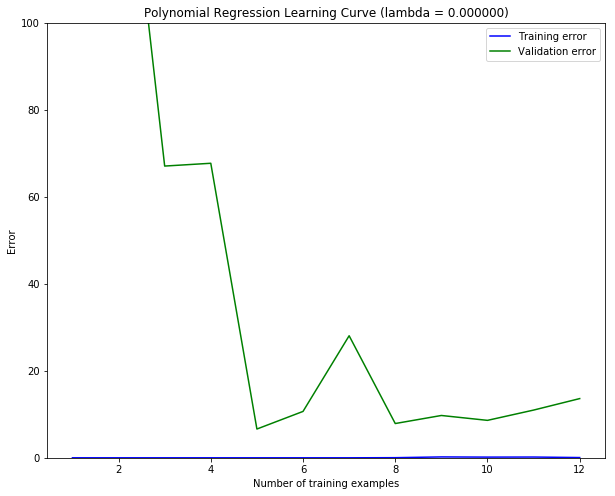

In [37]:
#plot data
x = np.arange(1,error_train.size + 1)

plt.figure(figsize=(10,8))
plt.plot(x,error_train,color='blue', label='Training error')
plt.plot(x,error_val,color='green', label='Validation error')

plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.title("Polynomial Regression Learning Curve (lambda = 0.000000)")
plt.ylim(0,100)

plt.legend(loc=1)

<b> 3.2 | Optional (ungraded) exercise: Adjusting the reg- ularization parameter </b>

In [38]:
theta = trainLinearReg(Xpolytrain,Ytrain, 1).x.reshape(-1,1)

In [40]:
X = np.arange( np.amin(Xtrain) - 15, np.amax(Xtrain) + 25, 0.05 ).reshape(-1,1)

Xpoly = map_features(X, 8)
Xpoly = np.column_stack((np.ones(len(Xpoly)), (Xpoly - mu)/sigma))

fit_poly_line = Xpoly.dot(theta)

(-80, 80)

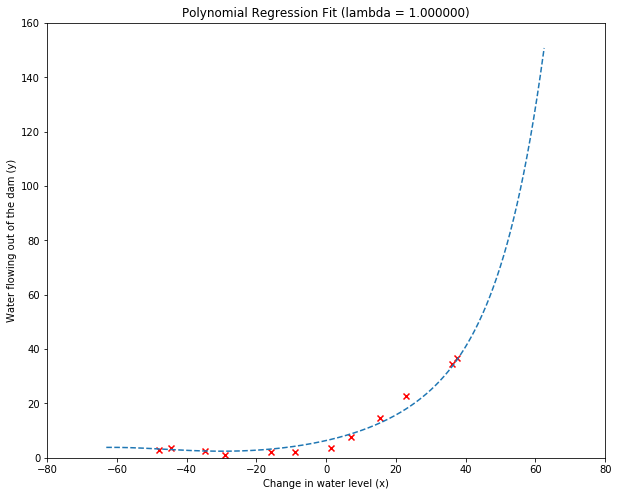

In [41]:
#plot data
plt.figure(figsize=(10,8))
plt.scatter(Xtrain[:,1],Ytrain,marker='x',c='r')
plt.plot(X, fit_poly_line, '--')

#Format chart
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.title('Polynomial Regression Fit (lambda = 1.000000)')
plt.ylim(0,160)
plt.xlim(-80,80)

In [42]:
error_train, error_val = learningCurve(Xpolytrain, Ytrain, Xpolyval, Yval, 1)

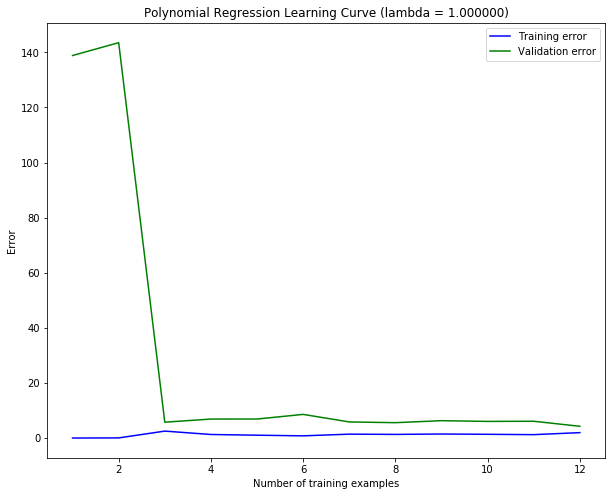

In [43]:
#plot data
x = np.arange(1,error_train.size + 1)

plt.figure(figsize=(10,8))
plt.plot(x, error_train,color='blue', label='Training error')
plt.plot(x, error_val,color='green', label='Validation error')

plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.title("Polynomial Regression Learning Curve (lambda = 1.000000)")

plt.legend(loc=1)

In [44]:
theta = trainLinearReg(Xpolytrain,Ytrain, 100).x.reshape(-1,1)

In [45]:
X = np.arange( np.amin(Xtrain) - 15, np.amax(Xtrain) + 25, 0.05 ).reshape(-1,1)

Xpoly = map_features(X, 8)
Xpoly = np.column_stack((np.ones(len(Xpoly)), (Xpoly - mu)/sigma))

fit_poly_line = Xpoly.dot(theta)

(-80, 80)

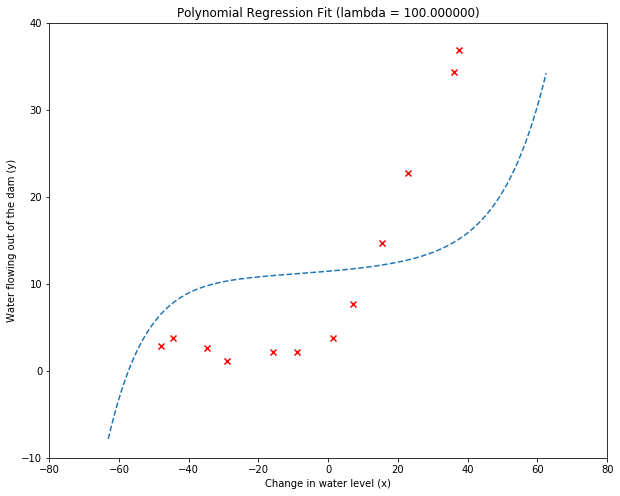

In [46]:
#plot data
plt.figure(figsize=(10,8))
plt.scatter(Xtrain[:,1],Ytrain,marker='x',c='r')
plt.plot(X, fit_poly_line, '--')

#Format chart
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.title('Polynomial Regression Fit (lambda = 100.000000)')
plt.ylim(-10,40)
plt.xlim(-80,80)

<b> 3.3 | Selecting λ using a cross validation set </b>

In [47]:
def validationCurve(Xtrain, Ytrain, Xval, Yval, lmda):
    
    error_train = np.zeros(lmbda.size)
    error_val = np.zeros(lmbda.size)
    
    for i in range(lmbda.size):
        res = trainLinearReg(Xtrain, Ytrain, lmda[i])
        theta = res.x.reshape(-1,1)

        htrain = np.dot(Xtrain, theta)
        hval = np.dot(Xval, theta)
        
        error_train[i] = np.sum((htrain - Ytrain)**2)/(2*Xtrain.shape[0])
        error_val[i] = np.sum((hval - Yval)**2)/(2*Xval.shape[0])
    
    return error_train, error_val

In [48]:
lmbda=np.array([0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]).reshape(-1,1)    

error_train, error_val = validationCurve(Xpolytrain, Ytrain, Xpolyval, Yval, lmbda)

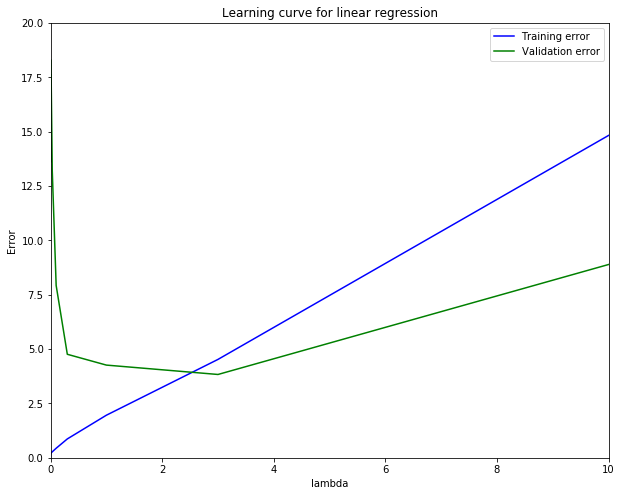

In [50]:
#plot data
plt.figure(figsize=(10,8))
plt.plot(lmbda,error_train,color='blue', label='Training error')
plt.plot(lmbda,error_val,color='green', label='Validation error')

plt.xlabel("lambda")
plt.ylabel("Error")
plt.title("Learning curve for linear regression")
plt.ylim(0,20)
plt.xlim(0,10)

plt.legend(loc=1)

In [53]:
#Find lambda for min error_val
error_val_lmbda = np.column_stack((lmbda, error_val))

i_min = 0
for i in range(error_val_lmbda.shape[0]):
    if error_val_lmbda[i,1] < error_val_lmbda[i_min,1]:
        i_min = i
        
lmbda_min = lmbda[i_min,0]

print('Approximate optimum lambda:',lmbda_min)

Approximate optimum lambda: 3.0


<b> 3.4 | Optional (ungraded) exercise: Computing test set error </b>

In [54]:
theta = trainLinearReg(Xpolytrain,Ytrain, lmbda_min).x.reshape(-1,1)

htest = np.dot(Xpolytest, theta)

error_test = np.sum((htest - Ytest)**2)/(2*Xtest.shape[0])

print('test error:', error_test)

test error: 3.5720266193199137
